- 测试 skirt 
    - padding+flips+flip hist+constract lr = 0.001
    - padding+flips+flip constract + hist lr = 0.0001
    - tta(pad+flip+constract)
- 测试 collar 
    - padding+flips+flip hist+constract lr = 0.001
    - padding+flips+flip constract + hist lr = 0.0001
    - tta(pad+flip+constract)

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import itertools
from skimage import data, img_as_float
from skimage import exposure

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 导入数据

In [2]:
import os

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

mkdir_if_not_exist(['./data/round2/preprocessing'])

In [3]:
df_train = pd.read_csv('./data/train/Annotations/label.csv')
df_train.columns = ['image_id', 'class', 'label']
df_train.head()

,image_id,class,label
0,Images/collar_design_labels/0ef580b4deabcd9fa4...,collar_design_labels,ynnnn
1,Images/collar_design_labels/87ccc33937821a97ad...,collar_design_labels,nnynn
2,Images/collar_design_labels/26caac7d1f1b36fb9d...,collar_design_labels,ynnnn
3,Images/collar_design_labels/396ab4e7cbc6798100...,collar_design_labels,nynnn
4,Images/collar_design_labels/fc4a679c2bf209de13...,collar_design_labels,ynnnn


In [4]:
classes = ['collar_design_labels', 'neckline_design_labels', 'skirt_length_labels',
          'sleeve_length_labels', 'neck_design_labels', 'coat_length_labels', 'lapel_design_labels',
          'pant_length_labels']

## 加载数据

In [5]:
cur_class = classes[1]
prefix_cls = cur_class.split('_')[0]

df_load = df_train[(df_train['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

neckline_design_labels: 16376


,image_id,class,label
0,Images/neckline_design_labels/ce4865335b52b79f...,neckline_design_labels,nnnnnynnnn
1,Images/neckline_design_labels/4f8654c099517d30...,neckline_design_labels,nnnnnnnynn
2,Images/neckline_design_labels/61052e51290d2960...,neckline_design_labels,nnnnnnnynn
3,Images/neckline_design_labels/e948921d89da972c...,neckline_design_labels,ynnnnnnnnn
4,Images/neckline_design_labels/6b81ca0da1970654...,neckline_design_labels,nnnnnnynnn


In [6]:
n_ration=0.9
df_valid=df_load[int(n_ration*len(df_load)):]
df_train=df_load[:int(n_ration*len(df_load))]

## 加载训练集

In [7]:
n = len(df_load)
n_class = len(df_load['label'][0])
width = 299 # 定义图片大小

In [8]:
n_valid = len(df_valid)

In [9]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [10]:
x_train_path='./bc/{}X_train_299_lr1.bc'.format(prefix_cls)
x_valid_path='./bc/{}X_valid_299_lr1.bc'.format(prefix_cls)
y_train_path='./bc/{}y_train_299_lr1.bc'.format(prefix_cls)
y_valid_path='./bc/{}y_vaild_299_lr1.bc'.format(prefix_cls)

In [11]:
X_train=load_array(x_train_path)
X_valid=load_array(x_valid_path)
y_train=load_array(y_train_path)
y_valid=load_array(y_valid_path)

In [12]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((65504, 299, 299, 3), (65504, 10), (4914, 299, 299, 3), (4914, 10))

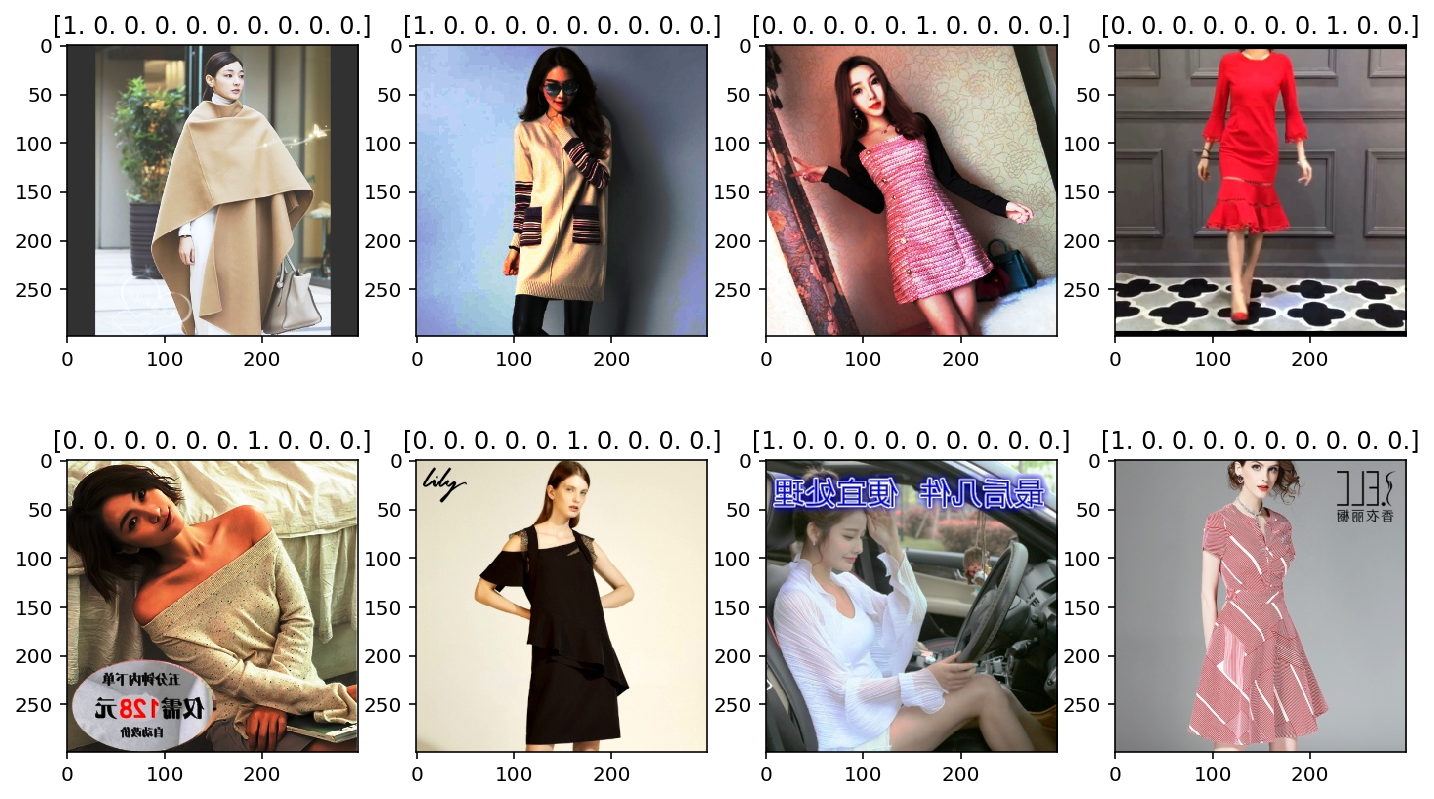

In [13]:
# 随机显示 8 张图片
plt.figure(figsize=(12, 7))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X_train[random_index][:,:,::-1])
    plt.title(y_train[random_index])

## 建立模型

In [14]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [15]:
cnn_model = InceptionResNetV2(include_top=False, input_shape=(width, width, 3), weights='imagenet')
inputs = Input((width, width, 3))

x = inputs
x = Lambda(preprocess_input, name='preprocessing')(x)
x = cnn_model(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax', name='softmax')(x)

model = Model(inputs, x)

In [16]:
model.load_weights('./models/{}.best0531a_InceptionResNetV2_round1.h5'.format(prefix_cls))

In [17]:
# for layer in cnn_model.layers:
#     layer.trainable = False

In [18]:
adam = Adam(lr=0.001)

In [19]:
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
checkpointer = ModelCheckpoint(filepath='./models/{0}.best0531a_InceptionResNetV2.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True, save_weights_only=True)

try:
    h = model.fit(X_train, y_train, batch_size=32, epochs=1, 
                  callbacks=[EarlyStopping(patience=3), checkpointer], 
                  shuffle=True, 
                  validation_data=(X_valid, y_valid))
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Train on 65504 samples, validate on 4914 samples
Epoch 1/1
65504/65504 [==============================] - 2169s 33ms/step - loss: 0.7185 - acc: 0.7587 - val_loss: 0.4423 - val_acc: 0.8610

Epoch 00001: val_loss improved from inf to 0.44235, saving model to ./models/neckline.best0531a_InceptionResNetV2.h5


In [26]:
# for layer in cnn_model.layers:
#     layer.trainable = True

In [21]:
import gc
del X_train
del y_train
gc.collect()

309750

In [22]:
x_train_path2='./bc/{}X_train_299_lr2.bc'.format(prefix_cls)
y_train_path2='./bc/{}y_train_299_lr2.bc'.format(prefix_cls)

In [23]:
X_train=load_array(x_train_path2)
y_train=load_array(y_train_path2)

In [24]:
# model.load_weights('./models/{}.best0529b_InceptionResNetV2.h5'.format(prefix_cls))

In [25]:
# 学习率减小 50 倍
adam = Adam(lr=0.0001)

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
checkpointer = ModelCheckpoint(filepath='./models/{0}.best0531a_InceptionResNetV2.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True, save_weights_only=True)

try:
    h = model.fit(X_train, y_train, batch_size=32, epochs=1, 
                  callbacks=[EarlyStopping(patience=3), checkpointer], 
                  shuffle=True, 
                  validation_data=(X_valid, y_valid))
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Train on 65504 samples, validate on 4914 samples
Epoch 1/1
65504/65504 [==============================] - 2169s 33ms/step - loss: 0.2078 - acc: 0.9322 - val_loss: 0.0723 - val_acc: 0.9807

Epoch 00001: val_loss improved from inf to 0.07231, saving model to ./models/neckline.best0531a_InceptionResNetV2.h5


In [27]:
# model.evaluate(X_valid, y_valid)

# 测试模型

In [28]:
y_comb = model.predict(X_valid, batch_size=256)

In [29]:
y_pred = np.zeros((n_valid, n_class))
y_valid2 = np.zeros((n_valid, n_class))

In [30]:
for i in range(n_valid):
    y_pred[i] = (y_comb[i*3 + 0] + y_comb[i*3 + 1] + y_comb[i*3+ 2])/3
    y_valid2[i] = (y_valid[i*3 + 0] + y_valid[i*3 + 1] + y_valid[i*3 + 2])/3

In [31]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_valid2, axis=1)

In [32]:
count = 0
for i in range(len(y_pred_classes)):
    if (y_true[i] != y_pred_classes[i]):
        count += 1

In [33]:
acc = (len(y_pred_classes)-count)/len(y_pred_classes)

In [34]:
print("true preds: {}/{}".format(len(y_pred_classes)-count, len(y_pred_classes)))
print("val_acc : {}".format(acc))

true preds: 1625/1638
val_acc : 0.9920634920634921


## 混淆矩阵

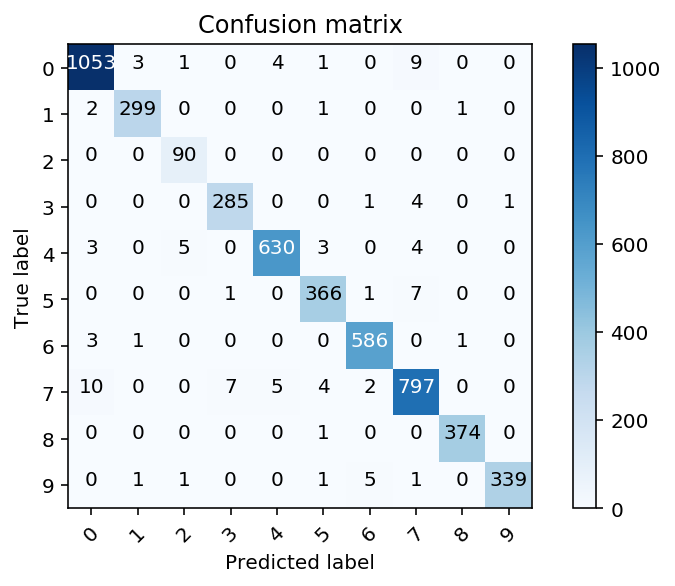

In [35]:
## sleeve: 0.8847

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This fuction prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Predict the values from the validation dataset
Y_pred = model.predict(X_valid)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_valid, axis=1)
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plt the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(n_class))

## 测试集数据预处理

In [35]:
mkdir_if_not_exist(['./data/test-preprocessing/Images/{}/'.format(cur_class)])

In [36]:
rootdir = './data/week-rank/Images/{}'.format(cur_class)  # 指明被遍历的文件夹
m = 0
outdir = './data/test-preprocessing/Images/{}/'.format(cur_class)

for parent, dirnames, filenames in os.walk(rootdir):
    for filename in filenames:
        currentPath = os.path.join(parent, filename)

        # 先填充, 再缩放
        img = cv2.imread(currentPath)
        row, column, channels = img.shape
        max_value = max(row, column)
        pad_img = cv2.copyMakeBorder(img,(max_value-row)//2,(max_value-row)//2,(max_value-column)//2,(max_value-column)//2,cv2.BORDER_CONSTANT)
        dst0 = cv2.resize(pad_img, (299, 299), interpolation=cv2.INTER_AREA)

#         # 顺时针旋转 5°/ 放大 5%
#         M1 = cv2.getRotationMatrix2D((cols/2,rows/2),5,1) 
#         M2 = cv2.getRotationMatrix2D((cols/2,rows/2),0,1.05) 
#         dst1 = cv2.warpAffine(dst0,M1,(cols,rows))
#         dst2 = cv2.warpAffine(dst0,M2,(cols,rows))
        
#         # 向下平移 0.2
#         M3 = np.float32([[1,0,0],[0,1,int(cols*0.2)]])
#         dst3 = cv2.warpAffine(dst0,M3,(cols,rows))
        
        # 水平翻转
        dst1 = cv2.flip(dst0, 1)
        
#         # 高斯噪声
#         dst0.astype("float")
#         Gauss_noise = np.random.normal(0, 20, (rows, cols, channels))
#         dst2 = dst0 + Gauss_noise
#         dst2 = np.where(dst2 < 0, 0, np.where(dst2 > 255, 255, dst2))
        
        # 直方图
        dst2 = exposure.equalize_hist(dst1)*255
        
        # 对比拉伸
        p2, p98 = np.percentile(dst0, (2, 98))
        dst3 = exposure.rescale_intensity(dst0, in_range=(p2, p98))
        
        cv2.imwrite(outdir + filename + "-0.jpg", dst0)
        cv2.imwrite(outdir + filename + "-1.jpg", dst1)
        cv2.imwrite(outdir + filename + "-2.jpg", dst2)
        cv2.imwrite(outdir + filename + "-3.jpg", dst3)
#         cv2.imwrite(outdir + filename + "-4.jpg", dst4.astype("uint8"))
#         cv2.imwrite(outdir + filename + "-5.jpg", dst5)
#         cv2.imwrite(outdir + filename + "-6.jpg", dst6)
#         cv2.imwrite(outdir + filename + "-7.jpg", dst7)
        m += 1
        if m%100 == 0:
            print('{} images have preprocessed.'.format(m))

100 images have preprocessed.
200 images have preprocessed.
300 images have preprocessed.
400 images have preprocessed.
500 images have preprocessed.
600 images have preprocessed.
700 images have preprocessed.
800 images have preprocessed.
900 images have preprocessed.
1000 images have preprocessed.
1100 images have preprocessed.
1200 images have preprocessed.
1300 images have preprocessed.
1400 images have preprocessed.
1500 images have preprocessed.


## 预处理图片进行全部预测

In [36]:
df_test = pd.read_csv('./data/week-rank/Tests/question.csv', header=None)
df_test.columns = ['image_id', 'class', 'x']
del df_test['x']
df_test.head()

,image_id,class
0,Images/collar_design_labels/1078bc9a4fa91aef69...,collar_design_labels
1,Images/collar_design_labels/272c5d069581efc94f...,collar_design_labels
2,Images/collar_design_labels/2e67922d82216cc756...,collar_design_labels
3,Images/collar_design_labels/d9726ceee17c7ee811...,collar_design_labels
4,Images/collar_design_labels/1b7de7f9def99a5aa6...,collar_design_labels


In [37]:
df_load2 = df_test[(df_test['class'] == cur_class)].copy()
df_load2.reset_index(inplace=True)
del df_load2['index']

print('{0}: {1}'.format(cur_class, len(df_load2)))
df_load2.head()

neckline_design_labels: 2714


,image_id,class
0,Images/neckline_design_labels/89d6bd83152ca94c...,neckline_design_labels
1,Images/neckline_design_labels/509a05b283b7d0fe...,neckline_design_labels
2,Images/neckline_design_labels/b2971f75a2bc83f6...,neckline_design_labels
3,Images/neckline_design_labels/7393a3c475d093e5...,neckline_design_labels
4,Images/neckline_design_labels/8bd6af5d69406b44...,neckline_design_labels


In [38]:
n = len(df_load2)
width = 299 # 定义图片大小
X_test = np.zeros((n*3, width, width, 3), dtype=np.uint8)

for i in tqdm(range(n)):
    for j in range(3):
        X_test[i*3+j] = cv2.resize(cv2.imread('./data/test-preprocessing/{0}'.format(df_load2['image_id'][i] + "-%s.jpg"%j)), (width, width))

100%|██████████| 2714/2714 [00:18<00:00, 147.76it/s]


In [39]:
# model.load_weights('./models/{}.best0520a_InceptionResNetV2.h5'.format(prefix_cls))

In [40]:
test_np = model.predict(X_test, batch_size=256)

In [41]:
# 取同一张图片不同预处理方式的平均值
result = []

for i, row in df_load2.iterrows():
    tmp_list = (test_np[i*3+0] + test_np[i*3+1] + test_np[i*3+2])/3
    tmp_result = ''
    for tmp_ret in tmp_list:
        tmp_result += '{:.4f};'.format(tmp_ret)
        
    result.append(tmp_result[:-1])

df_load2['result'] = result
df_load2.head()

,image_id,class,result
0,Images/neckline_design_labels/89d6bd83152ca94c...,neckline_design_labels,0.0027;0.0000;0.1525;0.0000;0.8436;0.0001;0.00...
1,Images/neckline_design_labels/509a05b283b7d0fe...,neckline_design_labels,0.0000;0.0003;0.0000;0.0000;0.0001;0.0000;0.00...
2,Images/neckline_design_labels/b2971f75a2bc83f6...,neckline_design_labels,0.0099;0.0000;0.9885;0.0000;0.0013;0.0000;0.00...
3,Images/neckline_design_labels/7393a3c475d093e5...,neckline_design_labels,0.0000;0.0006;0.0000;0.0000;0.0000;0.0000;0.00...
4,Images/neckline_design_labels/8bd6af5d69406b44...,neckline_design_labels,0.9747;0.0000;0.0002;0.0000;0.0211;0.0000;0.00...


In [42]:
df_load2.to_csv('./result/{}_0531a_InceptionResNetV2.csv'.format(prefix_cls), header=None, index=False)